In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

import pandas as pd
from sklearn.model_selection import train_test_split

from loguru import logger

## Download COCO-2017 dataset

**Selected classes for multi-class classification:**
 * cat
 * dog
 * horse


In [2]:
fo.list_datasets()

['coco2017-10k', 'coco2017-transportation']

In [3]:
dataset = foz.load_zoo_dataset(
    "coco-2017",
    splits=["train", "validation"],
    classes=["cat", "dog", "horse"],
    #max_samples=2000,
    only_matching=True,
)


session = fo.launch_app(dataset, auto=False)
session

Found annotations at '/home/pyml/fiftyone/coco-2017/raw/instances_train2017.json'
2000 images found; downloading the remaining 9117
 100% |████████████████| 9117/9117 [1.8m elapsed, 0s remaining, 86.9 images/s]       
Writing annotations for 11117 downloaded samples to '/home/pyml/fiftyone/coco-2017/train/labels.json'
Found annotations at '/home/pyml/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'train'
 100% |█████████████| 11117/11117 [5.5s elapsed, 0s remaining, 1.7K samples/s]      
Loading 'coco-2017' split 'validation'
 100% |█████████████████| 473/473 [193.9ms elapsed, 0s remaining, 2.5K samples/s]     
Dataset 'coco-2017-train-validation' created
Session launched. Run `session.show()` to open the App in a cell output.


Dataset:          coco-2017-train-validation
Media type:       image
Num samples:      11590
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/

In [4]:
sample = dataset.first()

sample

<Sample: {
    'id': '66f9983a55d599da07f8258c',
    'media_type': 'image',
    'filepath': '/home/pyml/fiftyone/coco-2017/train/data/000000000042.jpg',
    'tags': ['train'],
    'metadata': <ImageMetadata: {
        'size_bytes': None,
        'mime_type': None,
        'width': 640,
        'height': 478,
        'num_channels': None,
    }>,
    'ground_truth': <Detections: {
        'detections': [
            <Detection: {
                'id': '66f9983a55d599da07f8258b',
                'attributes': {},
                'tags': [],
                'label': 'dog',
                'bounding_box': [0.334609375, 0.0863807531380753, 0.54415625, 0.51],
                'mask': None,
                'confidence': None,
                'index': None,
                'supercategory': 'animal',
                'iscrowd': 0,
            }>,
        ],
    }>,
}>

## Filtering samples for multi-class

*Remove any sample that has more than one label"

In [5]:
list_samples = []

for sample in dataset:
    if sample["ground_truth.detections"] is None:
        continue
    labels = set([det["label"] for det in sample["ground_truth.detections"]])
    tag = sample["tags"][0]
    if len(labels) == 1:
        list_samples.append((sample["filepath"], labels.pop(), tag))

df = pd.DataFrame(list_samples, columns=["filepath", "label", "tag"])
df.head()

,filepath,label,tag
0,/home/pyml/fiftyone/coco-2017/train/data/00000...,dog,train
1,/home/pyml/fiftyone/coco-2017/train/data/00000...,horse,train
2,/home/pyml/fiftyone/coco-2017/train/data/00000...,dog,train
3,/home/pyml/fiftyone/coco-2017/train/data/00000...,dog,train
4,/home/pyml/fiftyone/coco-2017/train/data/00000...,dog,train


<Axes: title={'center': 'Number of samples per split'}, xlabel='tag'>

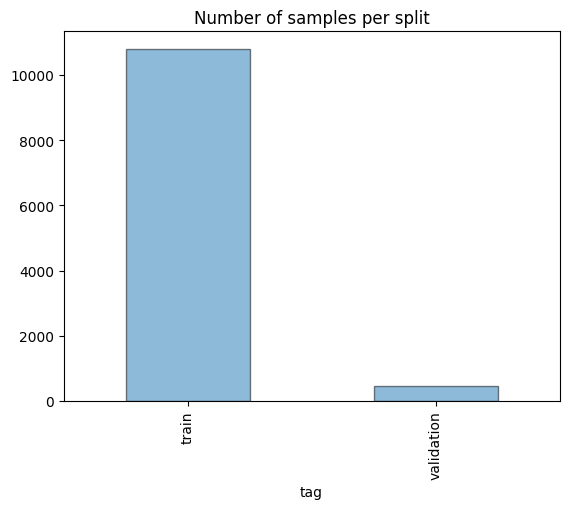

In [6]:
# bar plot of train/test/validation split
df["tag"].value_counts().plot(
    kind="bar", alpha=0.5, edgecolor="black",
    title="Number of samples per split"
)

<Axes: title={'center': 'Label distribution'}, xlabel='label'>

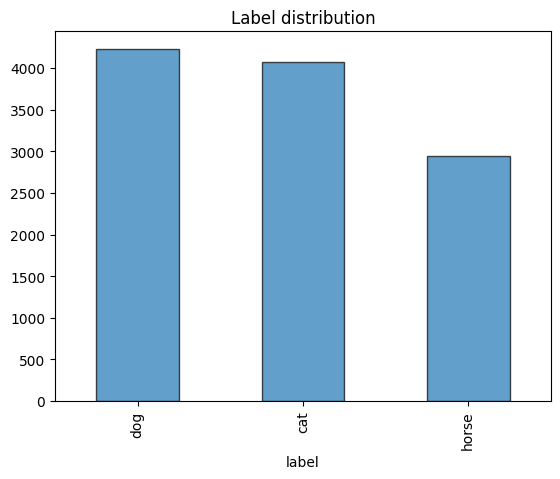

In [7]:
# bar plot of label distribution
df["label"].value_counts().plot(
    kind="bar", alpha=0.7, edgecolor="black",
    title="Label distribution"
)

In [8]:
logger.info(f"Number of samples: {len(df)}")
logger.info(f"Number of unique labels: {len(df['label'].unique())}")
logger.info(f"Number of Train samples: {len(df[df['tag'] == 'train'])}")
logger.info(f"Number of Validation samples: {len(df[df['tag'] == 'validation'])}")


2024-09-29 13:11:17.149 | INFO     | __main__:<module>:1 - Number of samples: 11251
2024-09-29 13:11:17.150 | INFO     | __main__:<module>:2 - Number of unique labels: 3
2024-09-29 13:11:17.153 | INFO     | __main__:<module>:3 - Number of Train samples: 10794
2024-09-29 13:11:17.153 | INFO     | __main__:<module>:4 - Number of Validation samples: 457


In [9]:
# use current validation set as test set
df_test = df[df["tag"] == "validation"].reset_index(drop=True)
df_test["tag"] = "test"

# split train -> train/val (80%/20%)
df_train = df[df["tag"] == "train"].reset_index(drop=True)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)
df_train["tag"] = "train"
df_val["tag"] = "val"

# concatenate
df = pd.concat([df_train, df_val, df_test]).reset_index(drop=True)

df.to_csv("data.csv", index=False)

In [10]:
dataset.delete()

In [11]:
logger.info(f"Number of samples: {len(df)}")
logger.info(f"Number of unique labels: {len(df['label'].unique())}")
logger.info(f"Number of Train samples: {len(df[df['tag'] == 'train'])}")
logger.info(f"Number of Validation samples: {len(df[df['tag'] == 'val'])}")
logger.info(f"Number of Test samples: {len(df[df['tag'] == 'test'])}")


2024-09-29 13:11:17.193 | INFO     | __main__:<module>:1 - Number of samples: 11251
2024-09-29 13:11:17.194 | INFO     | __main__:<module>:2 - Number of unique labels: 3
2024-09-29 13:11:17.196 | INFO     | __main__:<module>:3 - Number of Train samples: 8635
2024-09-29 13:11:17.196 | INFO     | __main__:<module>:4 - Number of Validation samples: 2159
2024-09-29 13:11:17.197 | INFO     | __main__:<module>:5 - Number of Test samples: 457
